In [1]:
import numpy
import control
from scipy import sparse
import osqp
from os.path import join

In [2]:
# PARAMETERS
# discretization
time_step = 0.01
method = "zoh"

# mechanical
k_r = 0.002
k_v = 0.1
r_g = 0.03 / 45
l = 0.1947 / 2
J = 0.75 * 0.019 * 0.03 * 0.03
m = 1.749
k_omega = 1.35
J_B = 0.75 * 1.749 * 0.1016 * 0.1016

# electrical
L = 0.05
R = 2
R_z = 0.2
K = 0.1
U_0 = 12

max_duty = 100.0

# composite
r_g_squared = r_g * r_g
comp_param_a = k_r + (k_v * r_g_squared) / 2
comp_param_b = J + (m * r_g_squared) / 2
comp_param_c = k_r * l + (k_omega * r_g_squared) / (2 * l)
comp_param_d = J * l + (J_B * r_g_squared) / (2 * l)

comp_param_e = -(R + R_z) / L
comp_param_f = -R_z / L
comp_param_g = -K / L

comp_param_h = K * (comp_param_d + comp_param_b * l) / (2 * comp_param_b * comp_param_d)
comp_param_i = K * (comp_param_d - comp_param_b * l) / (2 * comp_param_b * comp_param_d)
comp_param_j = -(comp_param_a * comp_param_d + comp_param_b * comp_param_c) / (2 * comp_param_b * comp_param_d)
comp_param_k = -(comp_param_a * comp_param_d - comp_param_b * comp_param_c) / (2 * comp_param_b * comp_param_d)

comp_param_l = U_0 / (L * max_duty)

# CONSTRAINTS
# state
state_constraint_margin = 1.1

stall_current = 0.7

max_input_rpm = 7300
gear_ratio = 45

# COSTS
# state stage/terminal
raw_state_costs = [0.0]*2 + [1.0]*2 # [currents] + [speeds]
state_costs = sparse.diags(raw_state_costs)

# input
raw_input_costs = [0.01]*2 # duty inputs
input_costs = sparse.diags(raw_input_costs) # duty inputs

# CONTROLLER PARAMETERS
prediction_horizons = 10

In [3]:
# Continuous time model
A = numpy.array([[comp_param_e, comp_param_f, comp_param_g, 0.0,        ],
                 [comp_param_f, comp_param_e, 0.0,          comp_param_g],
                 [comp_param_h, comp_param_i, comp_param_j, comp_param_k],
                 [comp_param_i, comp_param_h, comp_param_k, comp_param_j]])
B = numpy.array([[comp_param_l, 0.0],
                 [0.0,          comp_param_l],
                 [0.0,          0.0],
                 [0.0,          0.0]])

num_states = B.shape[0]
num_inputs = B.shape[1]
C = numpy.array([[0.0]*num_states]) # unused
D = numpy.array([[0.0]*num_inputs])

continuous_model = control.StateSpace(A, B, C, D)

In [4]:
# Discrete time model
discrete_model = continuous_model.sample(time_step, method)

In [204]:
continuous_model

StateSpace(array([[-4.40000000e+01, -4.00000000e+00, -2.00000000e+00,
         0.00000000e+00],
       [-4.00000000e+00, -4.40000000e+01,  0.00000000e+00,
        -2.00000000e+00],
       [ 7.58841007e+03, -2.04879706e+01, -1.52973360e+02,
         1.61323635e+00],
       [-2.04879706e+01,  7.58841007e+03,  1.61323635e+00,
        -1.52973360e+02]]), array([[2.4, 0. ],
       [0. , 2.4],
       [0. , 0. ],
       [0. , 0. ]]), array([[0., 0., 0., 0.]]), array([[0., 0.]]))

In [205]:
discrete_model

StateSpace(array([[ 3.32707643e-01, -1.72402518e-02, -6.04173010e-03,
         1.01219200e-04],
       [-1.72402518e-02,  3.32707643e-01,  1.01219200e-04,
        -6.04173010e-03],
       [ 2.29245997e+01, -4.45937792e-01,  3.22974450e-03,
         5.23167582e-03],
       [-4.45937792e-01,  2.29245997e+01,  5.23167582e-03,
         3.22974450e-03]]), array([[ 1.62140378e-02, -2.96812593e-04],
       [-2.96812593e-04,  1.62140378e-02],
       [ 4.44635621e-01, -5.20989638e-03],
       [-5.20989638e-03,  4.44635621e-01]]), array([[0., 0., 0., 0.]]), array([[0., 0.]]), 0.01)

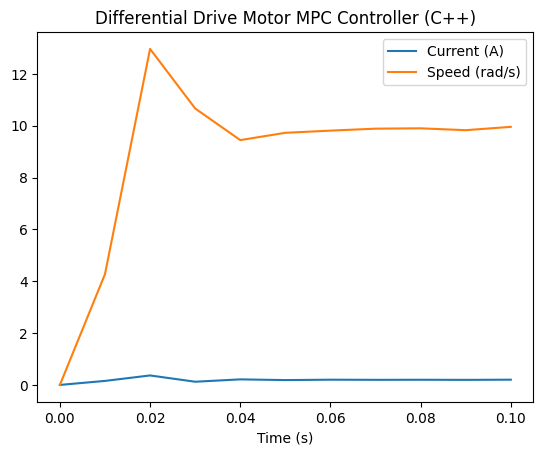

In [310]:
num_inputs = discrete_model.ninputs
u_original = numpy.array([9.73,   9.73,   21.5,   21.5,   5.32,   5.32,   15,   15,   11,   11,   12.6,   12.6,   12,   12,   12.3,   12.3,   12,   12,   12.5,   12.5,   11.6,   11.6])
u = numpy.vstack((u_original[::num_inputs], u_original[1::num_inputs]))
response = control.forced_response(discrete_model,
                                   T=numpy.arange(0, u.shape[1]*time_step, time_step),
                                   U=u,
                                   X0=x0)
plt.plot(response.t, response.x[0], label='Current (A)')
plt.plot(response.t, response.x[2], label='Speed (rad/s)')
plt.legend()
plt.title('Differential Drive Motor MPC Controller (C++)')
plt.xlabel('Time (s)')
plt.show()

In [206]:
for x in (umin, umax, xmin, xmax):
    print(x)

[-100. -100.]
[100. 100.]
[ -0.77        -0.77       -18.68665852 -18.68665852]
[ 0.77        0.77       18.68665852 18.68665852]


In [12]:
# Dense to sparse
Ad = sparse.csc_matrix(discrete_model.A)
Bd = sparse.csc_matrix(discrete_model.B)
[nx, nu] = (num_states, num_inputs)

# Constraints
max_current = state_constraint_margin * stall_current
max_speed = state_constraint_margin * max_input_rpm * 2 * numpy.pi / (gear_ratio * 60)
umin = numpy.array([-max_duty, -max_duty])
umax = numpy.array([max_duty,  max_duty])
xmin = numpy.array([-max_current, -max_current, # current
                    -max_speed, -max_speed]) # speed
xmax = numpy.array([max_current, max_current,
                    max_speed, max_speed])

# Objective function
Q = state_costs # state stage cost
QN = state_costs # state terminal cost
R = input_costs # input cost

# Initial and reference states, [currents] + [speeds]
x0 = numpy.zeros(num_states)
# xr = numpy.zeros(num_states)
xr = numpy.array([0.0]*2 + [10.0]*2)

# Prediction horizon
N = prediction_horizons

# Cast MPC problem to a QP: x = (x(0),x(1),...,x(N),u(0),...,u(N-1))
# - quadratic objective
P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN,
                       sparse.kron(sparse.eye(N), R)], format='csc')
# - linear objective
q = numpy.hstack([numpy.kron(numpy.ones(N), -Q.dot(xr)), -QN.dot(xr),
                  numpy.zeros(N*nu)])
# - linear dynamics
Ax = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + sparse.kron(sparse.eye(N+1, k=-1), Ad)
Bu = sparse.kron(sparse.vstack([sparse.csc_matrix((1, N)), sparse.eye(N)]), Bd)
Aeq = sparse.hstack([Ax, Bu])
leq = numpy.hstack([-x0, numpy.zeros(N*nx)])
ueq = leq
# - input and state constraints
Aineq = sparse.eye((N+1)*nx + N*nu)
lineq = numpy.hstack([numpy.kron(numpy.ones(N+1), xmin), numpy.kron(numpy.ones(N), umin)])
uineq = numpy.hstack([numpy.kron(numpy.ones(N+1), xmax), numpy.kron(numpy.ones(N), umax)])
# - OSQP constraints
A = sparse.vstack([Aeq, Aineq], format='csc')
l = numpy.hstack([leq, lineq])
u = numpy.hstack([ueq, uineq])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace
prob.setup(P, q, A, l, u, warm_start=False, adaptive_rho=False, verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 64, constraints m = 108
          nnz(P) + nnz(A) = 400
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 ,
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off



In [48]:
print(Ad.todense())

[[ 3.e-01 -2.e-02 -6.e-03  1.e-04]
 [-2.e-02  3.e-01  1.e-04 -6.e-03]
 [ 2.e+01 -4.e-01  3.e-03  5.e-03]
 [-4.e-01  2.e+01  5.e-03  3.e-03]]


In [50]:
print(Bd.todense())

[[ 2.e-02 -3.e-04]
 [-3.e-04  2.e-02]
 [ 4.e-01 -5.e-03]
 [-5.e-03  4.e-01]]


In [51]:
Ax.shape

(44, 44)

In [52]:
Bu.shape

(44, 20)

In [49]:
print(Ax.todense())

[[-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]


In [46]:
print(Bu.todense())

[[ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00]
 [ 2.e-02 -3.e-04  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00]
 [-3.e-04  2.e-02  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00

In [42]:
numpy.set_printoptions(precision=0)
print(Ax)
print(Bu)
print(Aeq)

  (0, 0)	-1.0
  (1, 1)	-1.0
  (2, 2)	-1.0
  (3, 3)	-1.0
  (4, 0)	0.33270764316207946
  (4, 1)	-0.017240251846276214
  (4, 2)	-0.006041730100449942
  (4, 3)	0.00010121919993567677
  (4, 4)	-1.0
  (5, 0)	-0.01724025184627622
  (5, 1)	0.33270764316207935
  (5, 2)	0.0001012191999356769
  (5, 3)	-0.006041730100449941
  (5, 5)	-1.0
  (6, 0)	22.924599659536476
  (6, 1)	-0.44593779234998066
  (6, 2)	0.003229744502010079
  (6, 3)	0.005231675824213005
  (6, 6)	-1.0
  (7, 0)	-0.4459377923499807
  (7, 1)	22.92459965953648
  (7, 2)	0.0052316758242130085
  (7, 3)	0.003229744502009857
  (7, 7)	-1.0
  (8, 4)	0.33270764316207946
  :	:
  (39, 32)	-0.4459377923499807
  (39, 33)	22.92459965953648
  (39, 34)	0.0052316758242130085
  (39, 35)	0.003229744502009857
  (39, 39)	-1.0
  (40, 36)	0.33270764316207946
  (40, 37)	-0.017240251846276214
  (40, 38)	-0.006041730100449942
  (40, 39)	0.00010121919993567677
  (40, 40)	-1.0
  (41, 36)	-0.01724025184627622
  (41, 37)	0.33270764316207935
  (41, 38)	0.0001012191

In [208]:
# generate the workspace for deployment on embedded (requires osqp recompile, so rather copy/paste matrices / vectors)
# prob.codegen(join("temp", "generated_ospq_workspace"), force_rewrite = True)

In [251]:
# FROM INPUT
# numpy output formatting
numpy.set_printoptions(precision=None)

# cpp formatting
cpp_spaces = 2
cpp_indent = " "*2

# writing to file for copy/paste
with open(join("temp", "generated_ospq_workspace.txt"), "w") as f:
    # general mpc attributes
    left_input_index = num_states*(N + 1)
    right_input_index = left_input_index + 1

    print(f"{cpp_indent}// mpc controller", file = f)
    print(f"{cpp_indent}constexpr int num_states {{{num_states}}};", file = f)
    print(f"{cpp_indent}constexpr int num_inputs {{{num_inputs}}};", file = f)
    print(f"{cpp_indent}constexpr float time_step {{{time_step}}};", file = f)
    print(f"{cpp_indent}constexpr int prediction_horizons {{{prediction_horizons}}};", file = f)
    print(f"{cpp_indent}constexpr c_float state_costs[{num_states}] {{{','.join(map(str, raw_state_costs))}}};", file = f)
    print(f"{cpp_indent}constexpr c_float input_costs[{num_inputs}] {{{','.join(map(str, raw_input_costs))}}};", file = f)
    print(f"{cpp_indent}constexpr int left_input_index {{{left_input_index}}};", file = f)
    print(f"{cpp_indent}constexpr int right_input_index {{{right_input_index}}};", file = f)
    print("", file = f)

    # matrices
    for name, description, matrix in (("P", "quadratic objective", sparse.csc_matrix(numpy.triu(P.todense(), -1))),
                                      ("A", "state constraint", A)):
        matrix_csc = matrix.tocsc()
        m = matrix_csc.shape[0]
        n = matrix_csc.shape[1]
        nzmax = matrix_csc.data.shape[0]
        data = matrix_csc.data
        indices = matrix_csc.indices
        indptr = matrix_csc.indptr

        print(f"{cpp_indent}// {description} matrix", file = f)
        print(f"{cpp_indent}constexpr c_int {name}_m {{{m}}};", file = f)
        print(f"{cpp_indent}constexpr c_int {name}_n {{{n}}};", file = f)
        print(f"{cpp_indent}constexpr c_int {name}_nzmax {{{nzmax}}};", file = f)
        print(f"{cpp_indent}c_float {name}_x[{nzmax}] {{{','.join(map(str, data))}}};", file = f)
        print(f"{cpp_indent}c_int {name}_i[{nzmax}] {{{','.join(map(str, indices))}}};", file = f)
        print(f"{cpp_indent}c_int {name}_p[{n + 1}] {{{','.join(map(str, indptr))}}};", file = f)
        print(f"{cpp_indent}csc {name}{{{name}_nzmax, {name}_m, {name}_n, {name}_p, {name}_i, {name}_x, -1}};", file = f)
        print("", file = f)

    # vectors
    names_descriptions_and_vectors = (("q", "linear objective", q),
                                      ("l", "lower bound", l),
                                      ("u", "upper bound", u))
    for index, (name, description, vector) in enumerate(names_descriptions_and_vectors):
        size = vector.shape[0]

        print(f"{cpp_indent}// {description} vector", file = f)
        print(f"{cpp_indent}c_float {name}[{size}] {{{','.join(map(str, vector))}}};", file = f)
        print(f"{cpp_indent}c_float {name}_update[{size}] {{{','.join(map(str, vector))}}};", file = f)
        if(index < (len(names_and_descriptions) - 1)):
            print("", file = f)

# FROM PROBE WORKSPACE INPUT
workspace_data = prob._model._get_workspace()["data"]

# numpy output formatting
numpy.set_printoptions(precision=None)

# cpp formatting
cpp_spaces = 2
cpp_indent = " "*2

# writing to file for copy/paste
with open(join("temp", "generated_ospq_workspace.txt"), "w") as f:
    # general mpc attributes
    left_input_index = num_states*(N + 1)
    right_input_index = left_input_index + 1

    print(f"{cpp_indent}// mpc controller", file = f)
    print(f"{cpp_indent}constexpr int num_states {{{num_states}}};", file = f)
    print(f"{cpp_indent}constexpr int num_inputs {{{num_inputs}}};", file = f)
    print(f"{cpp_indent}constexpr float time_step {{{time_step}}};", file = f)
    print(f"{cpp_indent}constexpr int prediction_horizons {{{prediction_horizons}}};", file = f)
    print(f"{cpp_indent}constexpr c_float state_costs[{num_states}] {{{','.join(map(str, raw_state_costs))}}};", file = f)
    print(f"{cpp_indent}constexpr c_float input_costs[{num_inputs}] {{{','.join(map(str, raw_input_costs))}}};", file = f)
    print(f"{cpp_indent}constexpr int left_input_index {{{left_input_index}}};", file = f)
    print(f"{cpp_indent}constexpr int right_input_index {{{right_input_index}}};", file = f)
    print("", file = f)

    # matrices
    for name, description in (("P", "quadratic objective"),
                              ("A", "state constraint")):
        matrix = workspace_data[name]
        m = matrix["m"]
        n = matrix["n"]
        nzmax = matrix["nzmax"]
        data = matrix["x"]
        indices = matrix["i"]
        indptr = matrix["p"]

        print(f"{cpp_indent}// {description} matrix", file = f)
        print(f"{cpp_indent}constexpr c_int {name}_m {{{m}}};", file = f)
        print(f"{cpp_indent}constexpr c_int {name}_n {{{n}}};", file = f)
        print(f"{cpp_indent}constexpr c_int {name}_nzmax {{{nzmax}}};", file = f)
        print(f"{cpp_indent}c_float {name}_x[{nzmax}] {{{','.join(map(str, data))}}};", file = f)
        print(f"{cpp_indent}c_int {name}_i[{nzmax}] {{{','.join(map(str, indices))}}};", file = f)
        print(f"{cpp_indent}c_int {name}_p[{n + 1}] {{{','.join(map(str, indptr))}}};", file = f)
        print(f"{cpp_indent}csc {name}{{{name}_nzmax, {name}_m, {name}_n, {name}_p, {name}_i, {name}_x, -1}};", file = f)
        print("", file = f)

    # vectors
    names_and_descriptions = (("q", "linear objective"),
                              ("l", "lower bound"),
                              ("u", "upper bound"))
    for index, (name, description) in enumerate(names_and_descriptions):
        vector = workspace_data[name]
        size = vector.shape[0]

        print(f"{cpp_indent}// {description} vector", file = f)
        print(f"{cpp_indent}c_float {name}[{size}] {{{','.join(map(str, vector))}}};", file = f)
        print(f"{cpp_indent}c_float {name}_update[{size}] {{{','.join(map(str, vector))}}};", file = f)
        if(index < (len(names_and_descriptions) - 1)):
            print("", file = f)

In [17]:
# define state state reference
state_reference = numpy.array([0.0]*2 + [10.0]*2)

In [8]:
# experimenting (zero reference state)
res = prob.solve()

print(res.x)
print(len(res.x))
print(res.y)
print(len(res.y))

iter   objective    pri res    dua res    rho        time
   1  -6.9365e+02   1.95e-01   6.38e+00   1.00e-01   9.02e-04s
  50  -9.8219e+02   2.15e-05   5.32e-03   1.00e-01   1.13e-03s

status:               solved
number of iterations: 50
optimal objective:    -982.1907
run time:             1.39e-03s
optimal rho estimate: 2.00e-03

[-5.43349866e-07 -5.43349866e-07 -1.02549960e-07 -1.02549960e-07
  3.41997841e-01  3.41997841e-01  9.44146559e+00  9.44146559e+00
  1.36477017e-01  1.36477017e-01  1.01051990e+01  1.01051990e+01
  2.21262189e-01  2.21262189e-01  9.73031562e+00  9.73031562e+00
  1.87717282e-01  1.87717282e-01  9.90710312e+00  9.90710312e+00
  2.00402447e-01  2.00402447e-01  9.82586137e+00  9.82586137e+00
  1.95597093e-01  1.95597093e-01  9.85386381e+00  9.85386381e+00
  1.98203478e-01  1.98203478e-01  9.86449221e+00  9.86449221e+00
  1.94887706e-01  1.94887706e-01  9.81065497e+00  9.81065497e+00
  2.01535044e-01  2.01535044e-01  9.93924578e+00  9.93924578e+00
  1.89921815e-0

In [18]:
# experimenting (non-zero reference state)
cost_fragment = -state_costs.dot(state_reference)
q_update = numpy.hstack([cost_fragment for _ in range(N + 1)] + [numpy.zeros(N*B.shape[1])])
prob.update(q=q_update)
res = prob.solve()

print(q_update)
print(res.x)
print(len(res.x))
print(res.y)
print(len(res.y))

iter   objective    pri res    dua res    rho        time
   1  -6.9365e+02   1.95e-01   6.38e+00   1.00e-01   2.28e-04s
  50  -9.8219e+02   2.15e-05   5.32e-03   1.00e-01   5.95e-04s

status:               solved
number of iterations: 50
optimal objective:    -982.1907
run time:             1.25e-03s
optimal rho estimate: 2.00e-03

[ -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0.
 -10. -10.  -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0. -10. -10.
  -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0.
 -10. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
[-5.43349866e-07 -5.43349866e-07 -1.02549960e-07 -1.02549960e-07
  3.41997841e-01  3.41997841e-01  9.44146559e+00  9.44146559e+00
  1.36477017e-01  1.36477017e-01  1.01051990e+01  1.01051990e+01
  2.21262189e-01  2.21262189e-01  9.73031562e+00  9.73031562e+00
  1.87717282e-01  1.87717282e-01  9.90710312e+00  9.90710312e+00
  2.00402447e-

In [29]:
# Simulate in closed loop
nsim = 10
x_list = list()

for i in range(nsim):
    # update state stage/terminal portion of linear objective
    cost_fragment = -state_costs.dot(state_reference)
    q_update = numpy.hstack([cost_fragment for _ in range(N + 1)] + [numpy.zeros(N*B.shape[1])])
    prob.update(q=q_update)
    print("q")
    print(q_update)

    # Solve
    res = prob.solve()
    # x_list.append(res.x)

    # Check solver status
    if res.info.status != 'solved':
        raise ValueError('OSQP did not solve the problem!')

    # Apply first control input to the plant
    ctrl = res.x[-N*nu:-(N-1)*nu]
    x0 = Ad.dot(x0) + Bd.dot(ctrl)
    print("x")
    print(res.x)

    # Update initial state
    l[:nx] = -x0
    u[:nx] = -x0
    print("l_update")
    print(l)
    prob.update(l=l, u=u)

q
[ -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0.
 -10. -10.  -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0. -10. -10.
  -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0. -10. -10.  -0.  -0.
 -10. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
x
[-1.64191954e-07 -1.64191954e-07  5.81610847e-06  5.81610847e-06
  3.62227598e-01  3.62227598e-01  9.99999715e+00  9.99999715e+00
  1.19088586e-01  1.19088586e-01  1.00000052e+01  1.00000052e+01
  2.40359292e-01  2.40359292e-01  9.99999565e+00  9.99999565e+00
  1.79873256e-01  1.79873256e-01  1.00000076e+01  1.00000076e+01
  2.10041560e-01  2.10041560e-01  9.99999586e+00  9.99999586e+00
  1.94994886e-01  1.94994886e-01  1.00000079e+01  1.00000079e+01
  2.02499295e-01  2.02499295e-01  9.99999668e+00  9.99999668e+00
  1.98756649e-01  1.98756649e-01  1.00000052e+01  1.00000052e+01
  2.00623131e-01  2.00623131e-01  9.99999817e+00  9.99999817e+00
  1.99692481e-01  1.

In [30]:
# state components
print(res.x) # [A.shape[1]] + [N*A.shape[1]] + [N*B.shape[1]]
print(res.x[-N*nu:-(N-1)*nu])
print(res.x[num_states*(N + 1)])
print(res.x[num_states*(N + 1) + 1])
print(x0)

[ 0.20062338  0.20062338  9.99999999  9.99999999  0.19969229  0.19969229
 10.00000012 10.00000012  0.2001568   0.2001568   9.99999999  9.99999999
  0.19992513  0.19992513 10.00000005 10.00000005  0.20004067  0.20004067
  9.99999995  9.99999995  0.19998305  0.19998305 10.00000004 10.00000004
  0.20001178  0.20001178  9.99999995  9.99999995  0.19999745  0.19999745
 10.00000004 10.00000004  0.2000046   0.2000046   9.99999997  9.99999997
  0.20000104  0.20000104 10.00000003 10.00000003  0.20000281  0.20000281
  9.99999999  9.99999999 12.30159279 12.30159279 12.34923112 12.34923112
 12.32547067 12.32547067 12.33732147 12.33732147 12.33141092 12.33141092
 12.33435866 12.33435866 12.3328887  12.3328887  12.33362162 12.33362162
 12.33325623 12.33325623 12.33343835 12.33343835]
[12.30159279 12.30159279]
12.301592787201194
12.301592787201205
[ 0.19969231  0.19969231 10.         10.        ]


In [31]:
n = 4
x = 4
y = 2

In [32]:
def isDivisible(n, x, y):
  return (n % (x*y)) == 0;

In [33]:
isDivisible(n,x,y)

False

In [27]:
x_osqp_test = [-7.84e-07,  -7.84e-07,   5.82e-06,   5.82e-06,   1.73,   1.73,   10,   10,   0.57,   0.57,   10,   10,   1.15,   1.15,   10,   10,   0.861,   0.861,   10,   10,   1.01,   1.01,   10,   10,   0.934,   0.934,   10,   10,   0.97,   0.97,   10,   10,   0.952,   0.952,   10,   10,   0.961,   0.961,   10,   10,   0.2,   0.2,   10,   10,   22.8,   22.8,   4.03,   4.03,   16.5,   16.5,   10.3,   10.3,   13.4,   13.4,   11.8,   11.8,   12.6,   12.6,   12.2,   12.2,   12.4,   12.4,   12.3,   12.3]

In [32]:
x_osqp_codegen = [-7.86e-07,  -7.86e-07,   5.82e-06,   5.82e-06,   1.73,   1.73,   10,   10,   0.57,   0.57,   10,   10,   1.15,   1.15,   10,   10,   0.861,   0.861,   10,   10,   1.01,   1.01,   10,   10,   0.934,   0.934,   10,   10,   0.97,   0.97,   10,   10,   0.952,   0.952,   10,   10,   0.961,   0.961,   10,   10,   0.2,   0.2,   10,   10,   22.8,   22.8,   4.03,   4.03,   16.5,   16.5,   10.3,   10.3,   13.4,   13.4,   11.8,   11.8,   12.6,   12.6,   12.2,   12.2,   12.4,   12.4,   12.3,   12.3]

In [20]:
def deep_equals(A, B):
    for i, (a, b) in enumerate(zip(A,B)):
        if a!=b:
            print(f"{i}, {a} != {b}")

In [33]:
deep_equals(x_osqp_test, x_osqp_codegen)

0, -7.84e-07 != -7.86e-07
1, -7.84e-07 != -7.86e-07


In [34]:
len(q_update)

64

In [39]:
num_states*(prediction_horizons+1)

44

In [42]:
num_states*(prediction_horizons+1) + num_inputs*(prediction_horizons)

64

In [37]:
prediction_horizons

10

In [38]:
q_update

array([ -0.,  -0., -10., -10.,  -0.,  -0., -10., -10.,  -0.,  -0., -10.,
       -10.,  -0.,  -0., -10., -10.,  -0.,  -0., -10., -10.,  -0.,  -0.,
       -10., -10.,  -0.,  -0., -10., -10.,  -0.,  -0., -10., -10.,  -0.,
        -0., -10., -10.,  -0.,  -0., -10., -10.,  -0.,  -0., -10., -10.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [11]:
prob._model._get_workspace()

{'rho_vectors': {'rho_vec': array([100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
         100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
         100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
         100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
         100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1]),
  'rho_inv_vec': array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
          0.01,  0.01

In [71]:
dir(prob)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_derivative_cache',
 '_model',
 'adjoint_derivative',
 'codegen',
 'derivative_iterative_refinement',
 'setup',
 'solve',
 'update',
 'update_settings',
 'version',
 'warm_start']

C++ vs Python

// defaults
core: https://osqp.org/docs/interfaces/solver_settings.html#solver-settings
python: https://github.com/osqp/osqp-python/blob/de9a29012f32377f0cb3282d741a010a5eba1d99/src/osqppurepy/_osqp.py

// objects
core: settings
python: prob._model._get_workspace()

// polish (not active)
delta: 1e-06 (default) / NA
polish_refine_iter: 3 (default) / NA

// adaptive rho (active)
adaptive_rho_interval: 0 / 25
adaptive_rho_tolerance: 5.0 / 5.0
adaptive_rho_fraction: 0.4 / 0.4

In [10]:
import osqp
import numpy as np
from scipy import sparse

# Define problem data
P = sparse.csc_matrix([[4, 1], [1, 2]])
q = np.array([1, 1])
A = sparse.csc_matrix([[1, 1], [1, 0], [0, 1]])
l = np.array([1, 0, 0])
u = np.array([1, 0.7, 0.7])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace and change alpha parameter
prob.setup(P, q, A, l, u, alpha=1.0, polish=True)

# Solve problem
res = prob.solve()
print("Solution")
print(res.x)

# Evaluate CSC representation
def csc_format(matrix):
    return (matrix.data, matrix.indices, matrix.indptr, matrix.nnz)

print("CSC Representation")
print(csc_format(P))
print(csc_format(A))

# Evaluate solutions
def evaluate_solution(x):
    objective = numpy.transpose(x)@P@x/2 + numpy.transpose(q)@x
    ax = A*x

    lower_bound_satisfied = (l <= ax).all()
    upper_bound_satisfied = (ax <= u).all()

    return (objective, lower_bound_satisfied, upper_bound_satisfied)

# Python
print("Python Solution Evaluation")
print(evaluate_solution(res.x))

# C++
print("C++ Solution Evaluation")
print(evaluate_solution(numpy.array([0.6, 1.0])))

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2, constraints m = 3
          nnz(P) + nnz(A) = 7
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.00, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -4.9384e-03   1.00e+00   2.00e+02   1.00e-01   8.64e-05s
  50   1.8800e+00   1.91e-07   7.50e-07   1.38e+00   1.93e-04s
plsh   1.8800e+00   0.00e+00   0.00e+00   --------  

In [53]:
# x = numpy.array([-6.67e-18,  -6.67e-18,  -2.54e-19,  -2.54e-19,   1.73,   1.73,   10,   10,   0.57,   0.57,   10,   10,   1.15,   1.15,   10,   10,   0.861,   0.861,   10,   10,   1.01,   1.01,   10,   10,   0.934,   0.934,   10,   10,   0.97,   0.97,   10,   10,   0.952,   0.952,   10,   10,   0.961,   0.961,   10,   10,   0.2,   0.2,   10,   10,   22.8,   22.8,   4.03,   4.03,   16.5,   16.5,   10.3,   10.3,   13.4,   13.4,   11.8,   11.8,   12.6,   12.6,   12.2,   12.2,   12.4,   12.4,   12.3,   12.3])
x = res.x
ax = A*x

lower_constraint = l <= ax
upper_constraint = ax <= u
constraints = lower_constraint & upper_constraint

print(x)
print(l)
print(lower_constraint)
print(ax)
print(u)
print(upper_constraint)
print(constraints)

[-7.e-18 -7.e-18 -3.e-19 -3.e-19  2.e+00  2.e+00  1.e+01  1.e+01  6.e-01
  6.e-01  1.e+01  1.e+01  1.e+00  1.e+00  1.e+01  1.e+01  9.e-01  9.e-01
  1.e+01  1.e+01  1.e+00  1.e+00  1.e+01  1.e+01  9.e-01  9.e-01  1.e+01
  1.e+01  1.e+00  1.e+00  1.e+01  1.e+01  1.e+00  1.e+00  1.e+01  1.e+01
  1.e+00  1.e+00  1.e+01  1.e+01  2.e-01  2.e-01  1.e+01  1.e+01  2.e+01
  2.e+01  4.e+00  4.e+00  2.e+01  2.e+01  1.e+01  1.e+01  1.e+01  1.e+01
  1.e+01  1.e+01  1.e+01  1.e+01  1.e+01  1.e+01  1.e+01  1.e+01  1.e+01
  1.e+01]
[  -0.   -0.   -0.   -0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.   -1.   -1.  -19.  -19.
   -1.   -1.  -19.  -19.   -1.   -1.  -19.  -19.   -1.   -1.  -19.  -19.
   -1.   -1.  -19.  -19.   -1.   -1.  -19.  -19.   -1.   -1.  -19.  -19.
   -1.   -1.  -19.  -19.   -1.   -1.  -19

In [31]:
l[:44]

array([-0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [32]:
u[:44]

array([-0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [33]:
ax[:44]

array([ 5.43349866e-07,  5.43349866e-07,  1.02549960e-07,  1.02549960e-07,
       -7.09025321e-07, -7.09025321e-07,  1.78232212e-05,  1.78232212e-05,
        6.96000454e-07,  6.96000455e-07, -2.15384698e-05, -2.15384698e-05,
       -5.23036796e-07, -5.23036796e-07,  1.99381180e-05,  1.99381180e-05,
        2.79336717e-07,  2.79336717e-07, -1.41252300e-05, -1.41252300e-05,
       -4.89313547e-08, -4.89313549e-08,  6.78618702e-06,  6.78618702e-06,
       -1.15932312e-07, -1.15932312e-07, -2.47640816e-07, -2.47640807e-07,
        1.95523007e-07,  1.95523007e-07, -4.14144714e-06, -4.14144714e-06,
       -1.91207558e-07, -1.91207558e-07,  5.93903579e-06,  5.93903579e-06,
        1.18637114e-07,  1.18637114e-07, -5.29443267e-06, -5.29443267e-06,
       -7.84328530e-10, -7.84328658e-10,  2.73499877e-06,  2.73499877e-06])

In [34]:
len(leq)

44

In [24]:
A*numpy.array([0.6, 1.0])

array([1.6, 0.6, 1. ])

In [72]:
prob._model._get_workspace()

{'rho_vectors': {'rho_vec': array([100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
         100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
         100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
         100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
         100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,
           0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1]),
  'rho_inv_vec': array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
          0.01,  0.01

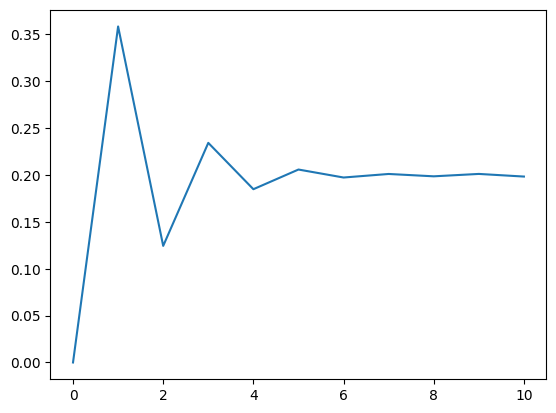

In [215]:
import matplotlib.pyplot as plt
plt.plot(res.x[0:(prediction_horizons+1)*num_states:4])

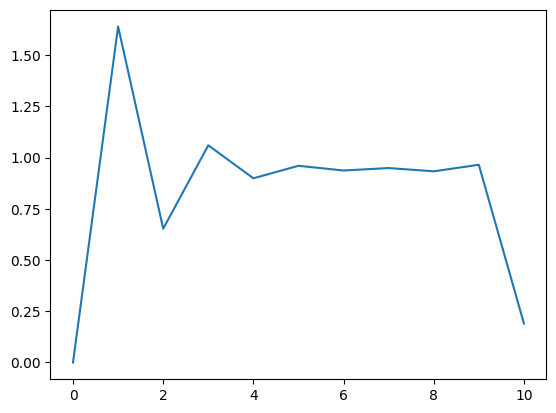

In [216]:
x_cpp = numpy.array([-2.59e-06,  -2.59e-06,  -1.03e-07,  -1.03e-07,   1.64,   1.64,   9.44,   9.44,   0.653,   0.653,   10.1,   10.1,   1.06,   1.06,   9.73,   9.73,   0.899,   0.899,   9.91,   9.91,   0.96,   0.96,   9.83,   9.83,   0.937,   0.937,   9.85,   9.85,   0.949,   0.949,   9.86,   9.86,   0.933,   0.933,   9.81,   9.81,   0.965,   0.965,   9.94,   9.94,   0.19,   0.19,   9.73,   9.73,   21.5,   21.5,   5.32,   5.32,   15,   15,   11,   11,   12.6,   12.6,   12,   12,   12.3,   12.3,   12,   12,   12.5,   12.5,   11.6,   11.6])
plt.plot(x_cpp[0:(prediction_horizons+1)*num_states:4])